In [52]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [53]:
df = pd.read_csv('/content/SPAM text message 20170820 - Data.csv')
df.tail()

,Category,Message
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [54]:
df.Category.value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [55]:
df['Category'] = df['Category'].apply(lambda x: 0 if x == 'spam' else 1)
df.tail()

,Category,Message
5567,0,This is the 2nd time we have tried 2 contact u...
5568,1,Will ü b going to esplanade fr home?
5569,1,"Pity, * was in mood for that. So...any other s..."
5570,1,The guy did some bitching but I acted like i'd...
5571,1,Rofl. Its true to its name


In [56]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [57]:
def Tahapan_Stopword(text):
  # tokenisasi teks
  words = word_tokenize(text) # Konversi text ke kata-kata

  # hapus stopwoerd
  stop_words = set(stopwords.words('english')) # Menghapus kata kaya yang tidak punya makna
  words = [word for word in words if word.lower() not in stop_words]

  return ' '.join(words)

def Tahapan_Stemming(text):
  stemmer = PorterStemmer()
  words = word_tokenize(text)

  stemmed_words = [stemmer.stem(word) for word in words] # Mereduksi kata-kata ke bentuk dasar
  return ' '.join(stemmed_words)

In [58]:
df['Stopwords'] = df['Message'].apply(Tahapan_Stopword)
df['Stemming'] = df['Stopwords'].apply(Tahapan_Stemming)
df.tail()

,Category,Message,Stopwords,Stemming
5567,0,This is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u. U £750 Pound prize...,2nd time tri 2 contact u. u £750 pound prize ....
5568,1,Will ü b going to esplanade fr home?,ü b going esplanade fr home ?,ü b go esplanad fr home ?
5569,1,"Pity, * was in mood for that. So...any other s...","Pity , * mood . ... suggestions ?","piti , * mood . ... suggest ?"
5570,1,The guy did some bitching but I acted like i'd...,guy bitching acted like 'd interested buying s...,guy bitch act like 'd interest buy someth els ...
5571,1,Rofl. Its true to its name,Rofl . true name,rofl . true name


In [60]:
pesan = df['Stemming'].values
label = df['Category'].values

In [61]:
pesan_latih, pesan_test, label_latih, label_test = train_test_split(pesan, label, test_size=0.2)

In [62]:
tokenizer = Tokenizer(num_words=250, oov_token='x')
tokenizer.fit_on_texts(pesan_latih)
tokenizer.fit_on_texts(pesan_test)

sekuens_latih = tokenizer.texts_to_sequences(pesan_latih)
sekuens_test = tokenizer.texts_to_sequences(pesan_test)

padded_latih = pad_sequences(sekuens_latih, maxlen=20)
padded_test = pad_sequences(sekuens_test, maxlen=20)

In [63]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(250, 16, input_length=20),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(24, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [64]:
#Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9 :
      print('\nAkurasi Model Sudah > 90%')
      self.model.stop_training = True

In [65]:
num_epochs = 30
history = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test), verbose=2, callbacks = myCallback())

Epoch 1/30
140/140 - 2s - loss: 0.5062 - accuracy: 0.8537 - val_loss: 0.3206 - val_accuracy: 0.8493 - 2s/epoch - 14ms/step
Epoch 2/30

Akurasi Model Sudah > 90%
140/140 - 0s - loss: 0.2075 - accuracy: 0.9248 - val_loss: 0.1617 - val_accuracy: 0.9516 - 340ms/epoch - 2ms/step


In [66]:
def plot_acc_loss(history):
  fig,ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].set_title('Loss')
  ax[0].plot(history.epoch, history.history['loss'],label = 'Train Loss')
  ax[0].plot(history.epoch, history.history['val_loss'],label = 'Valid Loss')
  ax[0].legend()

  ax[1].set_title('Accuracy')
  ax[1].plot(history.epoch, history.history['accuracy'],label = 'Train Accuracy')
  ax[1].plot(history.epoch, history.history['val_accuracy'],label = 'Valid Accuracy')
  ax[1].legend()

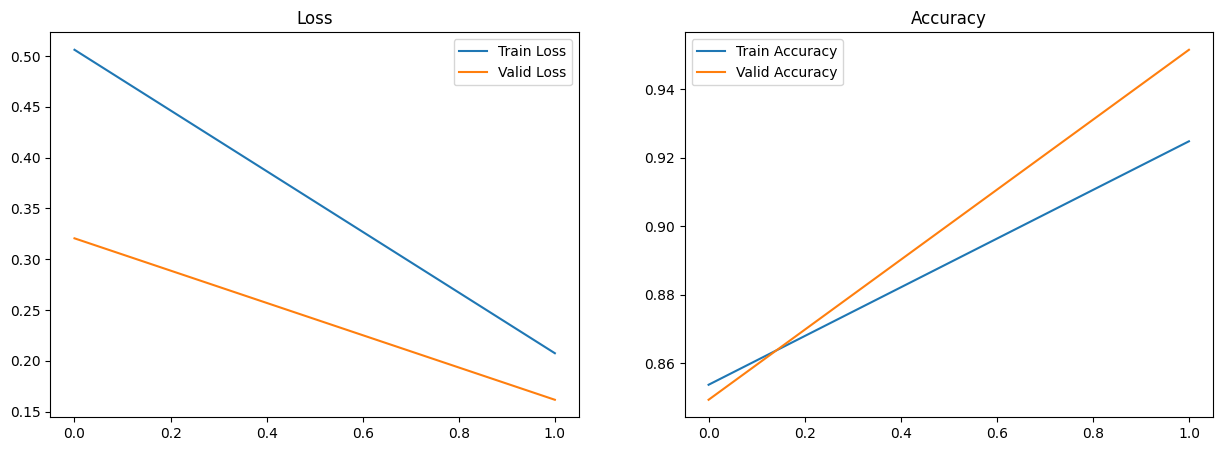

In [67]:
plot_acc_loss(history)

In [68]:
# Save model
model.save('/tmp/saved_model')

In [69]:
load_model = tf.keras.models.load_model('/tmp/saved_model')

In [136]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Fungsi untuk melakukan prediksi
def predict_spam(new_teks):
    max_len = load_model.input_shape[1]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts([new_teks])
    sekuens_teks = tokenizer.texts_to_sequences([new_teks])
    padding_teks = pad_sequences(sekuens_teks, maxlen = max_len)
    prediction = load_model.predict(padding_teks)
    if prediction[0][0] > 0.9366472:
        sentiment = 'Spam'
    else:
        sentiment = 'Not Spam'
    return prediction[0][0], sentiment

# Widget input teks
input_text = widgets.Textarea(
    value='',
    placeholder='Masukkan Teks',
    description='Teks:',
    disabled=False,
    layout=widgets.Layout(width='700px')
)

# Widget tombol prediksi
button_predict = widgets.Button(description="Prediksi")

# Widget output
output = widgets.Output()

# Fungsi yang dipanggil ketika tombol prediksi ditekan
def on_button_predict_clicked(b):
    with output:
        output.clear_output()
        prediction, sentiment = predict_spam(input_text.value)
        print(f'\nPrediksi: {prediction} - {sentiment} E-mail')
        print()

In [137]:
button_predict.on_click(on_button_predict_clicked)
display(input_text, button_predict,output)

Textarea(value='', description='Teks:', layout=Layout(width='700px'), placeholder='Masukkan Teks')

Button(description='Prediksi', style=ButtonStyle())

Output()